In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
#Read Data
ambition=pd.read_pickle('data/temp/ambition.pkl')
credits=pd.read_pickle('data/temp/credits_prices.pkl')
missing_credits=pd.read_pickle('data/temp/missing_credits_prices.pkl').rename(columns={'Quantity Issued':'credit_retired'})

control_var=pd.read_pickle('data/temp/combined_control.pkl')


scope1=pd.read_pickle('data/temp/scope1_total.pkl')

emission_overwrite=pd.read_excel('data/company_data/Data.xlsx', sheet_name='emission_overwrite').set_index('CDP_ID')


credits_cumulative=pd.read_excel('data/company_data/Data.xlsx', sheet_name='Credit_no_2018_2023').set_index('CDP_ID')

reporting_years=pd.read_excel('data/company_data/Data.xlsx', sheet_name='Reporting_year').set_index('CDP_ID')




# extract year for which companies report
reporting_years['end_year']=reporting_years['end_date'].dt.year



# Select control variables for correct reporting year
control_var=control_var.set_index('CDP_ID')
control_var['revenue']=np.nan
for i in control_var.index:
    if i in reporting_years.index:
   
        if reporting_years.loc[i,'end_year']==2022:
            control_var.loc[i,'revenue']=control_var.loc[i,'TOTAL_REV_FY2022']
        elif reporting_years.loc[i,'end_year']==2023:
            control_var.loc[i,'revenue']=control_var.loc[i,'TOTAL_REV_FY2023']
control_var=control_var.reset_index()


# Overwritre emisson data where approriate
for i in emission_overwrite.index:
    if emission_overwrite.loc[i, 'scope1_2023']>0:
        scope1.loc[i, 'scope1_2023']=float(emission_overwrite.loc[i, 'scope1_2023'])
    if emission_overwrite.loc[i, 'scope1_2018']>0:
        scope1.loc[i, 'scope1_2018']=float(emission_overwrite.loc[i, 'scope1_2018'])




# sum up money spent on carbon credits for CDP data
credits_id = credits.groupby('Account number')['money_spent'].sum().reset_index()


# sum up money spent on carbon credits for registry data
missing_credits_id = missing_credits.groupby('CDP_ID')['money_spent'].sum().reset_index()

# select rows where no credits are missing
filtered_credits_id = credits_id[~credits_id['Account number'].isin(missing_credits_id['CDP_ID'])]

# Rename the column in missing_credits_id to match credits_id
missing_credits_id.rename(columns={'CDP_ID': 'Account number'}, inplace=True)

# combine CDP and registry data
combined_credits = pd.concat([filtered_credits_id, missing_credits_id], ignore_index=True)

# sum money spent for each company
final_credits = combined_credits.groupby('Account number')['money_spent'].sum()

credits_id=final_credits

## Cumulative credits
# Selecting the columns for the specified years
columns = [2018, 2019, 2020, 2021, 2022, 2023]

# get all retired credits for the years 2018-2023
credits_2018_2023= credits_cumulative[columns].apply(pd.to_numeric, errors='coerce').sum(axis=1, skipna=False)
credits_2018_2023.to_pickle('data/temp/credits_2018_2023.pkl')



# Sum number of credits for each company in the CDP data
credits_no = credits.groupby('Account number')['credit_retired'].sum().reset_index()


# Sum number of credits for each company in the registry data
missing_credits_no = missing_credits.groupby('CDP_ID')['credit_retired'].sum().reset_index()

# Select rows where no credits are missing
filtered_credits_no = credits_no[~credits_no['Account number'].isin(missing_credits_no['CDP_ID'])]

# Rename the column in missing_credits_no to match credits_no
missing_credits_no.rename(columns={'CDP_ID': 'Account number'}, inplace=True)

# Combine CDP and registry data
combined_credit_number = pd.concat([filtered_credits_no, missing_credits_no], ignore_index=True)

# Sum number of credits for each company
final_credits_number = combined_credit_number.groupby('Account number')['credit_retired'].sum()

credit_number=final_credits_number

#Avianca purchased to not pay colombian carbon tax - set voluntary retirement to 0
credit_number.loc[50174]=0
credits_id.loc[50174]=0


# Save result
credit_number.to_pickle('data/temp/credit_number.pkl')



# build amibotion dataframe
ambition['credit_spent']=credits_id
ambition['credit_spent']=ambition['credit_spent'].fillna(0)
ambition['offset_share']=(100*(credit_number/scope1['scope1_2023']).replace(np.nan, 0))
ambition['credit_number']=credit_number
ambition['credit_number']=ambition['credit_number'].fillna(0)
ambition['credit_2018_2023']=credits_2018_2023


scope1['credit_spent']=credits_id
scope1['credit_spent']=scope1['credit_spent'].fillna(0)
scope1['credit_number']=credit_number
scope1['credit_number']=scope1['credit_number'].fillna(0)
scope1['credit_2018_2023']=credits_2018_2023



SyntaxError: invalid syntax (1589447671.py, line 2)

In [ ]:
ambition.sort_values(by='weighted_ambition', ascending=False)

,index,scope1_ambition,scope2_ambition,scope3_ambition,Sector,scope1_coverage,scope2_coverage,scope3_coverage,scope1_intensity,scope2_intensity,...,scope1_share,scope2_share,scope3_share,weighted_ambition,weighted_intermediate_coverage,weighted_intensity_coverage,credit_spent,offset_share,credit_number,credit_2018_2023
CDP_ID,,,,,,,,,,,,,,,,,,,,,
840836,Volvo Group,2.825974,2.825974,1.931681,Automobile,100.0,100.0,73.610219,0.0,0.0,...,0.005119,0.008950,0.985932,1.944263,73.981480,72.574645,0.00,0.000000,0.0,0.0
866803,Mercedes-Benz Group,1.874925,1.874925,1.507995,Automobile,100.0,100.0,73.610219,0.0,0.0,...,0.005119,0.008950,0.985932,1.513157,73.981480,72.574645,4591023.36,119.770826,681496.0,687589.0
10076,KIA,-3.749966,-3.749966,-0.902546,Automobile,100.0,100.0,73.610219,0.0,0.0,...,0.005119,0.008950,0.985932,-0.942605,73.981480,0.000000,0.00,0.000000,0.0,0.0
1932,BMW Group,3.821449,3.821449,-1.365895,Automobile,100.0,100.0,73.610219,100.0,100.0,...,0.005119,0.008950,0.985932,-1.292918,73.981480,73.981480,7083738.75,122.688482,851528.0,1716158.0
8708,Hyundai Motor,-0.111504,-0.111504,-1.513765,Automobile,100.0,100.0,0.000000,0.0,0.0,...,0.005119,0.008950,0.985932,-1.494038,1.406834,0.000000,0.00,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8362,"Hino Motors, Ltd.",-14.133398,-14.133398,-18.443257,Automobile,60.0,60.0,0.000000,0.0,0.0,...,0.005119,0.008950,0.985932,-18.382625,0.844101,0.000000,0.00,0.000000,0.0,0.0
58656,NFI Group Inc.,-18.443257,-18.443257,-18.443257,Automobile,100.0,0.0,0.000000,0.0,0.0,...,0.005119,0.008950,0.985932,-18.443257,0.511878,0.000000,0.00,0.000000,0.0,NaN
44253,Grupo Aeromexico SAB de CV,-18.443257,-18.443257,-18.443257,Airline,0.0,0.0,0.000000,0.0,0.0,...,0.732103,0.003224,0.264673,-18.443257,0.000000,0.000000,30548.65,0.108415,4145.0,NaN


In [ ]:
ambition.loc[550]

index                             All Nippon Airways
scope1_ambition                            -7.642656
scope2_ambition                            -7.642656
scope3_ambition                           -18.197721
Sector                                       Airline
scope1_coverage                                100.0
scope2_coverage                                100.0
scope3_coverage                            48.048137
scope1_intensity                                 0.0
scope2_intensity                                 0.0
scope3_intensity                                 0.0
scope1_share                                0.732103
scope2_share                                0.003224
scope3_share                                0.264673
weighted_ambition                         -10.436294
weighted_intermediate_coverage             86.249759
weighted_intensity_coverage                      0.0
credit_spent                                 1120.24
offset_share                                0.

In [ ]:
ambition.loc[5170]

index                                 easyJet
scope1_ambition                     -7.216735
scope2_ambition                     -6.441272
scope3_ambition                    -13.049123
Sector                                Airline
scope1_coverage                         100.0
scope2_coverage                           0.0
scope3_coverage                         100.0
scope1_intensity                        100.0
scope2_intensity                          0.0
scope3_intensity                        100.0
scope1_share                         0.732103
scope2_share                         0.003224
scope3_share                         0.264673
weighted_ambition                   -8.757909
weighted_intermediate_coverage      99.677556
weighted_intensity_coverage         99.677556
credit_spent                      47964725.29
offset_share                        98.517294
credit_number                       6326223.0
credit_2018_2023                   11595697.0
Name: 5170, dtype: object

In [ ]:
control_var.columns.unique()

Index(['CDP_ID', 'SP_ENTITY_NAME', 'SP_ENTITY_ID', 'TOTAL_REV_FY2023',
       'TOTAL_REV_FY2022', 'TOTAL_REV_FY2021', 'TOTAL_REV_FY2020',
       'TOTAL_REV_FY2019', 'TOTAL_REV_FY2018', 'TOTAL_REV_FY2017',
       'EBITDA_FY2023', 'EBITDA_FY2022', 'EBITDA_FY2020', 'EBITDA_FY2021',
       'EBITDA_FY2019', 'EBITDA_FY2018', 'TOTAL_ASSETS_FY2023',
       'TOTAL_ASSETS_FY2022', 'TOTAL_ASSETS_FY2021', 'TOTAL_ASSETS_FY2020',
       'TOTAL_ASSETS_FY2019', 'TOTAL_ASSETS_FY2018', 'TOTAL_EMPLOYEES_FY2023',
       'TOTAL_EMPLOYEES_FY2022', 'TOTAL_EMPLOYEES_FY2021',
       'TOTAL_EMPLOYEES_FY2020', 'TOTAL_EMPLOYEES_FY2019',
       'TOTAL_EMPLOYEES_FY2018', 'CAPEX_FY2023', 'CAPEX_FY2022',
       'CAPEX_FY2021', 'CAPEX_FY2020', 'CAPEX_FY2019', 'CAPEX_FY2018',
       'Company Name', 'Country', 'Sector', 'Continent', 'revenue'],
      dtype='object')

In [ ]:
ambition.to_pickle('data/temp/ambition_offset_share.pkl')

## Target Ambition

### Number of Credits

Regression of number of retired credits on Climate Target Ambition in latest reporting year. We do not consider PJSC Lukoil due to heavy disrpution of Russian gas trade in study period.


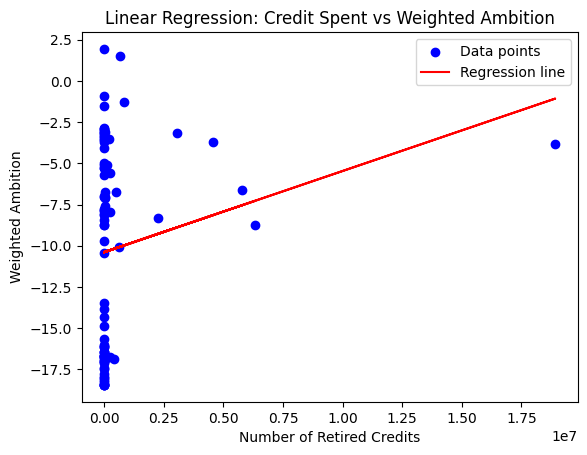

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Extracting the features and target variable
X = ambition[['credit_number']]
y = ambition['weighted_ambition']

# Creating and fitting the model
model = LinearRegression()
model.fit(X, y)

# Predicting values
y_pred = model.predict(X)

# Plotting the regression line
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, y_pred, color='red', label='Regression line')
plt.xlabel('Number of Retired Credits')
plt.ylabel('Weighted Ambition')
plt.title('Linear Regression: Credit Spent vs Weighted Ambition')
plt.legend()
plt.show()

Values not standardised

In [ ]:
#Regression without standardized values

import statsmodels.api as sm

regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID']!=11043]


regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)


# Adding a constant term to the predictor
#X = sm.add_constant(regression_df[['credit_number',  'revenue','Sector_Automobile','Sector_O&G','Continent_Europe','Continent_Latam','Continent_North America']])
X = sm.add_constant(regression_df[['credit_number','weighted_intermediate_coverage',  'revenue','Sector_Automobile','Sector_O&G','Continent_Europe','Continent_Latam','Continent_North America']])

# Fitting the regression model
model = sm.OLS(regression_df['weighted_ambition'], X.astype(float)).fit()

# Printing the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      weighted_ambition   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     9.222
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           6.57e-09
Time:                        09:41:15   Log-Likelihood:                -258.28
No. Observations:                  89   AIC:                             534.6
Df Residuals:                      80   BIC:                             557.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Values standardised using scaler.fit_transform()

In [ ]:
#Regression with standardized values
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)


# Selecting the predictors
predictors = ['credit_number', 'weighted_intermediate_coverage', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_credit_number = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_credit_number.summary())

                            OLS Regression Results                            
Dep. Variable:      weighted_ambition   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     9.222
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           6.57e-09
Time:                        10:38:26   Log-Likelihood:                -258.28
No. Observations:                  89   AIC:                             534.6
Df Residuals:                      80   BIC:                             557.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
#Not presented in paper - only for testing purposes. Dropping automobile industry instead of airline industry as a reference
#Regression with standardized values
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=False)


# Selecting the predictors
predictors = ['credit_number', 'weighted_intermediate_coverage', 'revenue', 
              'Sector_Airline', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_credit_number_automobile = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_credit_number_automobile.summary())

                            OLS Regression Results                            
Dep. Variable:      weighted_ambition   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     9.222
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           6.57e-09
Time:                        10:38:24   Log-Likelihood:                -258.28
No. Observations:                  89   AIC:                             534.6
Df Residuals:                      80   BIC:                             557.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Standardizing the predictors
scaler = StandardScaler()



# Separate regressions for stepwise inclusion
# 1. Only credit number
X_1 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number']]))
model_1 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_1).fit()

# 2. Credit number + weighted ambition
X_2 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'weighted_intermediate_coverage']]))
model_2 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_2).fit()

# 3. Credit number + weighted ambition + revenue
X_3 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'weighted_intermediate_coverage', 'revenue']]))
model_3 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_3).fit()

# 4. Credit number + weighted ambition + revenue + sectors
X_4 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'weighted_intermediate_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G']]))
model_4 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_4).fit()

# 5. Credit number + weighted ambition + revenue + sectors + continents
X_5 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'weighted_intermediate_coverage', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]))
model_5 = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_5).fit()

# Generate LaTeX table for all models with significance levels
# Using summary_col to compare multiple models and export to LaTeX format
regression_results = summary_col([model_1, model_2, model_3, model_4, model_5], 
                                 stars=True, float_format="%.4f",
                                 model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'],
                                 info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}", 
                                            'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}"})

# Printing the results in LaTeX format
print(regression_results.as_latex())


\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
               & Model 1     & Model 2     & Model 3     & Model 4     & Model 5      \\
\hline
const          & -10.0535*** & -10.0535*** & -10.0535*** & -10.0535*** & -10.0535***  \\
               & (0.6446)    & (0.5790)    & (0.5728)    & (0.5179)    & (0.4927)     \\
x1             & 1.0834*     & 0.4375      & 0.2496      & 0.2208      & 0.1587       \\
               & (0.6446)    & (0.5952)    & (0.5993)    & (0.5530)    & (0.5303)     \\
x2             &             & 2.7820***   & 2.6364***   & 1.6169**    & 0.8013       \\
               &             & (0.5952)    & (0.5952)    & (0.6172)    & (0.6472)     \\
x3             &             &             & 1.0038*     & 1.5586**    & 1.1999*      \\
               &             &             & (0.5936)    & (0.6405)    & (0.6211)     \\
x4             &             &             &             & 0.4076      & 0.3371       \\
               &       

/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_18624/179516439.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='#1f77b4')


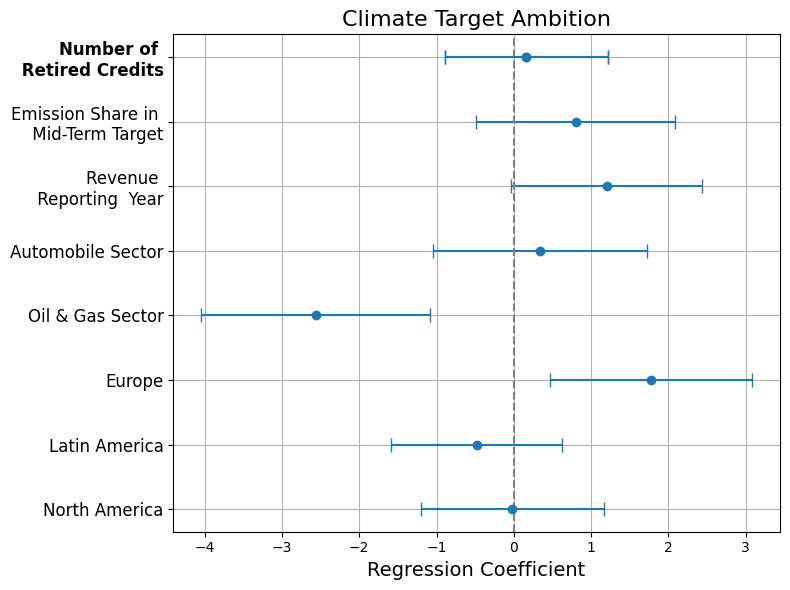

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the model has been already fitted and available as 'model'

# Extract coefficients and confidence intervals
coefficients = model_credit_number.params.drop('const')
conf = model_credit_number.conf_int()
conf['coef'] = coefficients
conf.columns = ['2.5%', '97.5%', 'coef']

# Optional: Standardize coefficients
X_std = regression_df[['credit_number', 'weighted_intermediate_coverage', 'revenue', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']].std()
y_std = regression_df['weighted_ambition'].std()
conf['coef_std'] = conf['coef'] * X_std / y_std
conf['2.5%_std'] = conf['2.5%'] * X_std / y_std
conf['97.5%_std'] = conf['97.5%'] * X_std / y_std

# Reverse the order of predictors
conf = conf[::-1]

# Manually set predictor names
conf.index = ['North America', 'Latin America', 'Europe', 'Oil & Gas Sector', 'Automobile Sector', 'Revenue Reporting Year', 'Emission Share in Mid-Term Target', 'Number of Retired Credits','const']

# Plotting the coefficients
plt.figure(figsize=(8, 6))
plt.errorbar(conf['coef'], conf.index, xerr=(conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']), fmt='o', capsize=5)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Climate Target Ambition', fontsize=16)
#plt.ylabel('Predictors')
plt.xlabel('Regression Coefficient', fontsize=14)



# Introduce a line break in the specific y-tick label
new_labels = conf.index.tolist()

position = len(conf) - 4
new_labels[position] = 'Revenue \n Reporting  Year'  # Adding line break

position = len(conf) - 3
new_labels[position] = 'Emission Share in \n Mid-Term Target'  # Adding line break

position = len(conf) - 2
new_labels[position] = 'Number of \n Retired Credits'  # Adding line break
plt.yticks(ticks=range(len(conf)), labels=new_labels, fontsize=12)



position=len(conf)-2
# Change the color of the uppermost point and error bar
plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='#1f77b4')


# Highlight the uppermost ylabel
#plt.gca().get_yticklabels()[position].set_color('red')
plt.gca().get_yticklabels()[position].set_color('black')
plt.gca().get_yticklabels()[position].set_fontweight('bold')



plt.grid(True)
plt.tight_layout()




plt.savefig('visualization/figures/effect_size/ambition_cont_regression.png', dpi=900)


### Leave-one-out Cross-Validation

Leaving easyJet and Delta Air Lines out influence regression the most. Since they are the largest offsetters, that is expected.

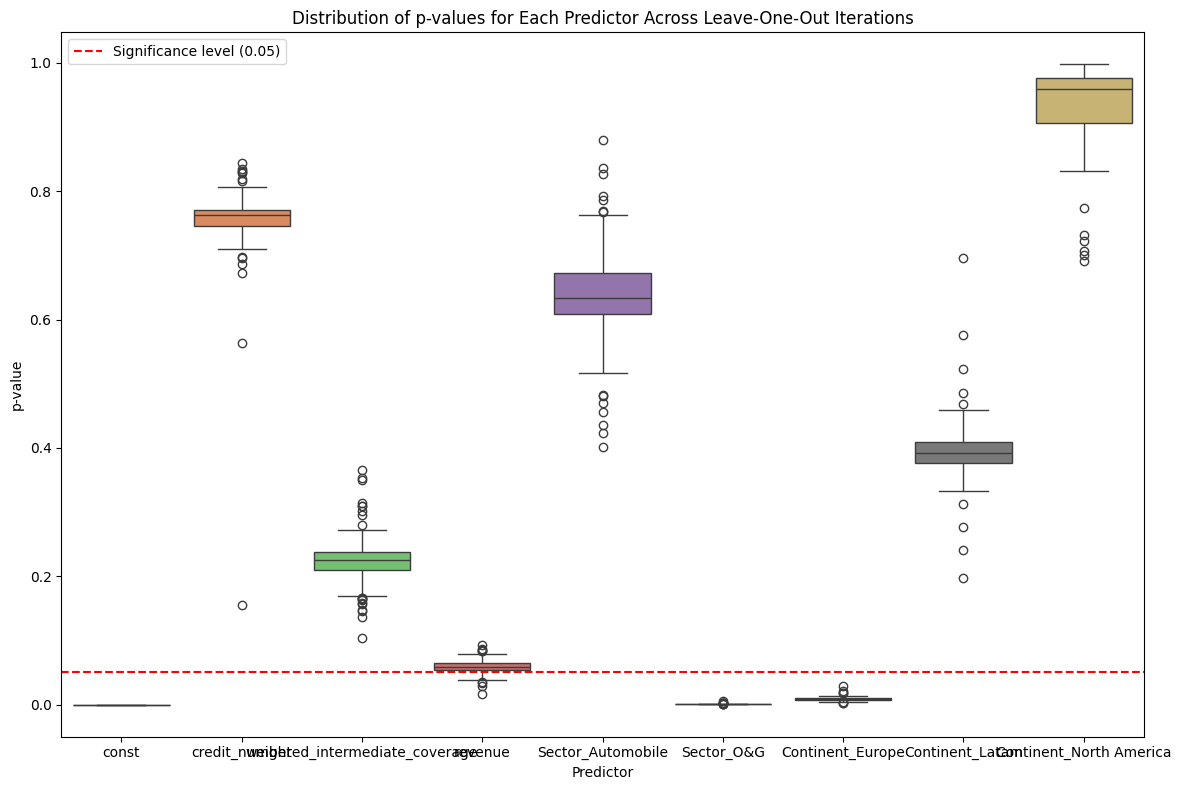

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are defined

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]




# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True).reset_index(drop=True)

# Defining predictors and outcome variable
predictors = ['credit_number', 'weighted_intermediate_coverage', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']
outcome = 'weighted_ambition'

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# Adding a constant term to the predictors
X_scaled_df = sm.add_constant(X_scaled_df)

# Dictionary to store p-values for each leave-one-out regression
p_values_dict = {predictor: [] for predictor in ['const'] + predictors}

# Run regressions excluding one observation at a time
for i in range(len(regression_df)):
    # Exclude one observation (row)
    X_excl = X_scaled_df.drop(i)
    y_excl = regression_df[outcome].drop(i)
    y_excl = y_excl.reset_index(drop=True)
    X_excl = X_excl.reset_index(drop=True)
    
    # Fit regression model
    model = sm.OLS(y_excl, X_excl).fit()
    
    # Store p-values for each predictor
    for predictor in p_values_dict.keys():
        p_values_dict[predictor].append(model.pvalues[predictor])

# Convert dictionary to DataFrame for easier plotting
p_values_df = pd.DataFrame(p_values_dict)

# Plotting p-values for each predictor across leave-one-out iterations
# Plotting p-values using a violin plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_df, palette="muted")
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Predictor')
plt.ylabel('p-value')
plt.title('Distribution of p-values for Each Predictor Across Leave-One-Out Iterations')
plt.legend()
plt.tight_layout()
plt.show()

## Climate Target Ambition with Dummy Variable
Instead of continuous variable for offsetting, we use a dummy variable that equals 1 if a company offset more than 10,000 carbon credits in CDP's 2023 Reporting wave


In [ ]:
#Regression with standardized values
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are already defined DataFrames

# Merging the dataframes
regression_df = pd.merge(ambition, control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023', 'TOTAL_ASSETS_FY2023', 'Continent']], on='CDP_ID', how='left')
regression_df = regression_df[regression_df['CDP_ID'] != 11043]

regression_df['credits_bin']=regression_df['credit_bin'] = (regression_df['credit_number'] > 1).astype(int)

# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)


# Selecting the predictors
predictors = ['credit_bin', 'weighted_intermediate_coverage', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictors
X_scaled = sm.add_constant(X_scaled_df[predictors])


# Fitting the regression model
model_credit_binary_ambition = sm.OLS(regression_df['weighted_ambition'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_credit_binary_ambition.summary())

                            OLS Regression Results                            
Dep. Variable:      weighted_ambition   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     9.352
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           5.12e-09
Time:                        09:41:18   Log-Likelihood:                -257.98
No. Observations:                  89   AIC:                             534.0
Df Residuals:                      80   BIC:                             556.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_18624/2103778691.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='#1f77b4')


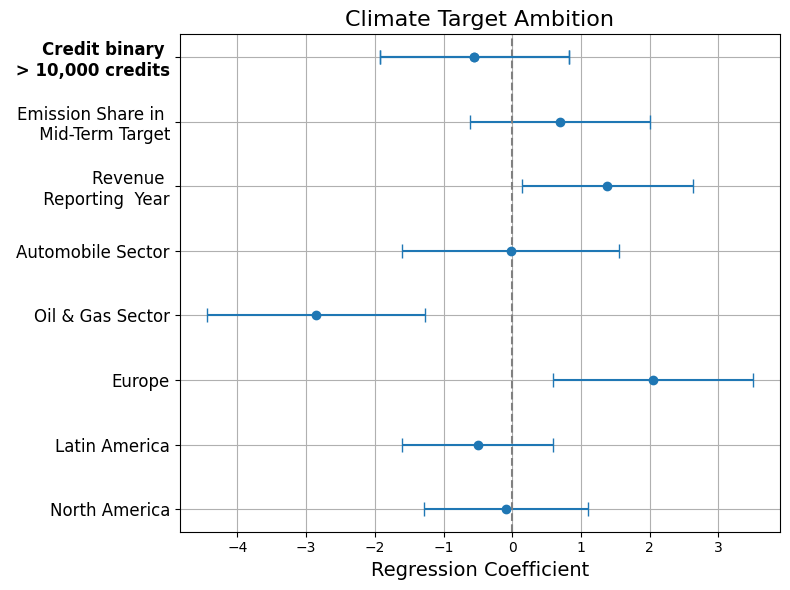

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the model has been already fitted and available as 'model'

# Extract coefficients and confidence intervals
coefficients = model_credit_binary_ambition.params.drop('const')
conf = model_credit_binary_ambition.conf_int()
conf['coef'] = coefficients
conf.columns = ['2.5%', '97.5%', 'coef']

# Optional: Standardize coefficients
X_std = regression_df[['credit_number', 'weighted_intermediate_coverage', 'revenue', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']].std()
y_std = regression_df['weighted_ambition'].std()
conf['coef_std'] = conf['coef'] * X_std / y_std
conf['2.5%_std'] = conf['2.5%'] * X_std / y_std
conf['97.5%_std'] = conf['97.5%'] * X_std / y_std

# Reverse the order of predictors
conf = conf[::-1]

# Manually set predictor names
conf.index = ['North America', 'Latin America', 'Europe', 'Oil & Gas Sector', 'Automobile Sector', 'Revenue Reporting Year', 'Emission Share in Mid-Term Target', 'Credit binary \n > 10,000 credits','const']

# Plotting the coefficients
plt.figure(figsize=(8, 6))
plt.errorbar(conf['coef'], conf.index, xerr=(conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']), fmt='o', capsize=5)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Climate Target Ambition', fontsize=16)
#plt.ylabel('Predictors')
plt.xlabel('Regression Coefficient', fontsize=14)



# Introduce a line break in the specific y-tick label
new_labels = conf.index.tolist()

position = len(conf) - 4
new_labels[position] = 'Revenue \n Reporting  Year'  # Adding line break

position = len(conf) - 3
new_labels[position] = 'Emission Share in \n Mid-Term Target'  # Adding line break

position = len(conf) - 2
new_labels[position] = 'Credit binary \n > 10,000 credits'  # Adding line break
plt.yticks(ticks=range(len(conf)), labels=new_labels, fontsize=12)



position=len(conf)-2
# Change the color of the uppermost point and error bar
plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='#1f77b4')


# Highlight the uppermost ylabel
#plt.gca().get_yticklabels()[position].set_color('red')
plt.gca().get_yticklabels()[position].set_color('black')
plt.gca().get_yticklabels()[position].set_fontweight('bold')



plt.grid(True)
plt.tight_layout()




plt.savefig('visualization/figures/effect_size/ambition_bin_regression.png', dpi=900)


## Scope 1 emissions ration CDP 2023 / CDP 2018
Regression of number of retired credits on change in scope 1 emissions vs. 2018 (scope 1 2023 / scope 1 2018) -> if change in scope 1 emissions is <1, emission decreased

### Continous Variable for carbon credits

We leave INPEX Corporation, Mercedes-Benz, and PJSC Lukoil out. Reasons: 
INPEX: Outlier - strongly influences results (see Manuscript). 
Mercedes-Benz: Re-structuring during study period. In 2021 Daimler Trucks was spun out. 
PJSC Lukoil: heavy disrpution of Russian gas trade in study period

In [ ]:
import statsmodels.api as sm




# Selecting the predictors
predictors = ['credit_number', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']




drop_list=[11043, 866803, 9134]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]


regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])

X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictor
X_scaled = sm.add_constant(X_scaled_df[predictors])

# Fitting the regression model
model_scope1_share_cont = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_scope1_share_cont.summary())



                            OLS Regression Results                            
Dep. Variable:      scope1_difference   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.268
Date:                Thu, 16 Jan 2025   Prob (F-statistic):              0.279
Time:                        09:41:21   Log-Likelihood:                -4.9364
No. Observations:                  78   AIC:                             25.87
Df Residuals:                      70   BIC:                             44.73
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col

# Assuming ambition and control_var are already defined DataFrames

drop_list=[11043, 866803, 9134]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]


regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)

# Standardizing the predictors
scaler = StandardScaler()



# Separate regressions for stepwise inclusion
# 1. Only credit number
X_1 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number']]))
model_1 = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_1).fit()



# 3. Credit number + weighted ambition + revenue
X_2 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'revenue']]))
model_2 = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_2).fit()

# 4. Credit number + weighted ambition + revenue + sectors
X_3 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G']]))
model_3 = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_3).fit()

# 5. Credit number + weighted ambition + revenue + sectors + continents
X_4 = sm.add_constant(scaler.fit_transform(regression_df[['credit_number', 'revenue', 
                                                         'Sector_Automobile', 'Sector_O&G', 
                                                         'Continent_Europe', 'Continent_Latam', 'Continent_North America']]))
model_4 = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_4).fit()

# Generate LaTeX table for all models with significance levels
# Using summary_col to compare multiple models and export to LaTeX format
regression_results = summary_col([model_1, model_2, model_3, model_4], 
                                 stars=True, float_format="%.4f",
                                 model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
                                 info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}", 
                                            'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}"})

# Printing the results in LaTeX format
print(regression_results.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
               & Model 1   & Model 2   & Model 3   & Model 4    \\
\hline
const          & 0.9412*** & 0.9412*** & 0.9412*** & 0.9412***  \\
               & (0.0313)  & (0.0314)  & (0.0304)  & (0.0308)   \\
x1             & -0.0178   & -0.0115   & 0.0055    & 0.0035     \\
               & (0.0313)  & (0.0321)  & (0.0325)  & (0.0333)   \\
x2             &           & -0.0295   & -0.0587*  & -0.0495    \\
               &           & (0.0321)  & (0.0350)  & (0.0370)   \\
x3             &           &           & 0.0371    & 0.0343     \\
               &           &           & (0.0404)  & (0.0430)   \\
x4             &           &           & 0.0983**  & 0.0893**   \\
               &           &           & (0.0403)  & (0.0416)   \\
x5             &           &           &           & -0.0171    \\
               &           &           &           & (0.0374)   \\
x6             &           &           &   

/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_18624/3095240034.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='#1f77b4')


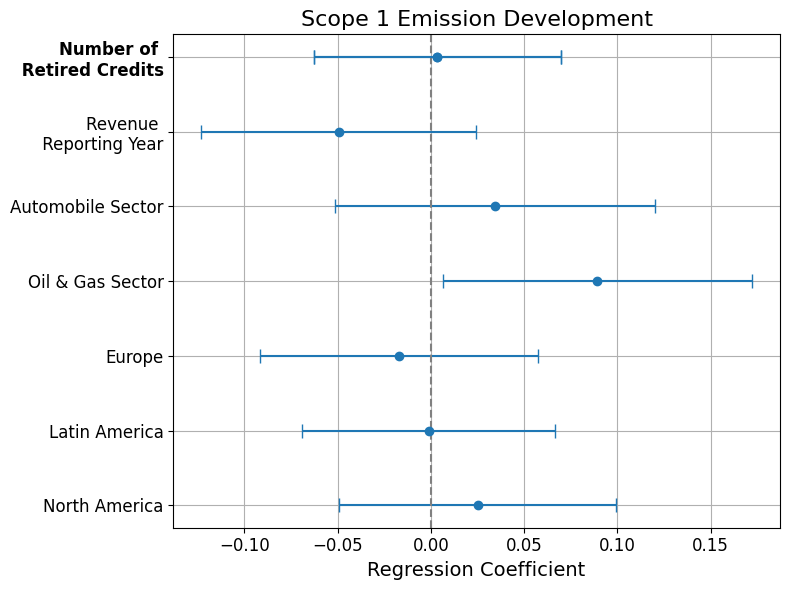

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the model has been already fitted and available as 'model'

# Extract coefficients and confidence intervals
coefficients = model_scope1_share_cont.params.drop('const')
conf = model_scope1_share_cont.conf_int()
conf['coef'] = coefficients
conf.columns = ['2.5%', '97.5%', 'coef']

# Optional: Standardize coefficients
X_std = regression_df[['credit_number', 'revenue', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']].std()
y_std = regression_df['scope1_difference'].std()
conf['coef_std'] = conf['coef'] * X_std / y_std
conf['2.5%_std'] = conf['2.5%'] * X_std / y_std
conf['97.5%_std'] = conf['97.5%'] * X_std / y_std

# Reverse the order of predictors
conf = conf[::-1]

# Manually set predictor names
conf.index = ['North America', 'Latin America', 'Europe', 'Oil & Gas Sector', 'Automobile Sector', 'Revenue Reporting Year',  'Number of Retired Credits', 'const']

# Plotting the coefficients
plt.figure(figsize=(8, 6))
plt.errorbar(conf['coef'], conf.index, xerr=(conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']), fmt='o', capsize=5)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Scope 1 Emission Development', fontsize=16)


# Introduce a line break in the specific y-tick label
new_labels = conf.index.tolist()

position = len(conf) - 3
new_labels[position] = 'Revenue \n Reporting Year'  # Adding line break



position = len(conf) - 2
new_labels[position] = 'Number of \n Retired Credits'  # Adding line break
plt.yticks(ticks=range(len(conf)), labels=new_labels, fontsize=12)
plt.xticks( fontsize=12)



position=len(conf)-2
# Change the color of the uppermost point and error bar
plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='#1f77b4')

# Highlight the uppermost ylabel
plt.gca().get_yticklabels()[position].set_color('black')
plt.gca().get_yticklabels()[position].set_fontweight('bold')

#plt.ylabel('Predictors')
plt.xlabel('Regression Coefficient', fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.savefig('visualization/figures/effect_size/scope1_cont_regression.png', dpi=900)

### Leave-one-out Cross Validatoin
For each regression run one observation is dropped. Below is distrubtion of p-values

#### Version 1: INPEX is part of sample
Red dot marks iteration where INPEX is dropped

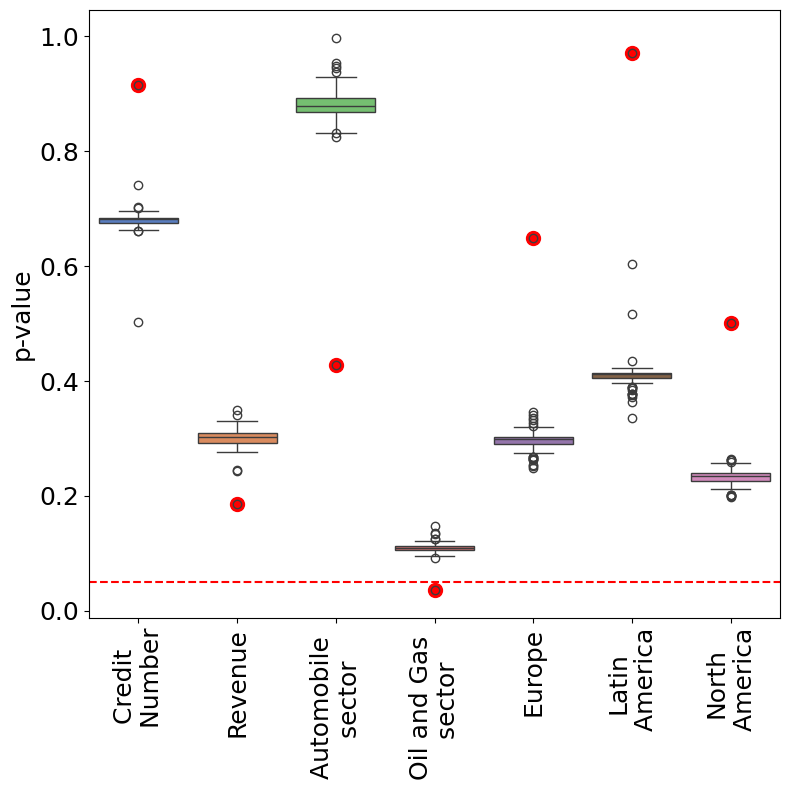

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are defined
# Selecting the predictors
predictors = ['credit_number', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']
outcome = 'scope1_difference'

# Merging the dataframes
drop_list=[11043, 866803]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]



# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True).reset_index(drop=True)

# Defining predictors and outcome variable


# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# Adding a constant term to the predictors
X_scaled_df = sm.add_constant(X_scaled_df)

# Dictionary to store p-values for each leave-one-out regression
p_values_dict = {predictor: [] for predictor in ['const'] + predictors}

# Run regressions excluding one observation at a time
for i in range(len(regression_df)):
    # Exclude one observation (row)
    X_excl = X_scaled_df.drop(i)
    y_excl = regression_df[outcome].drop(i)
    y_excl = y_excl.reset_index(drop=True)
    X_excl = X_excl.reset_index(drop=True)
    
    # Fit regression model
    model = sm.OLS(y_excl, X_excl).fit()
    
    # Store p-values for each predictor
    for predictor in p_values_dict.keys():
        p_values_dict[predictor].append(model.pvalues[predictor])

# Convert dictionary to DataFrame for easier plotting
p_values_df = pd.DataFrame(p_values_dict)
p_values_df = p_values_df.drop('const', axis=1)


# Plotting p-values for each predictor across leave-one-out iterations
plt.figure(figsize=(8, 8))

# Boxplot
sns.boxplot(data=p_values_df, palette="muted")

# Add scatter points
sns.stripplot(data=p_values_df, color="gray", alpha=0.0, jitter=True, size=8)

# Highlight index 47
index_inpex=regression_df[regression_df['CDP_ID']==9134].index[0]
for col in p_values_df.columns:
    plt.scatter(x=[col], y=[p_values_df.at[index_inpex, col]], color="red", s=100, label='Inpex Corporation left out' if col == p_values_df.columns[0] else "")

# Add significance level line
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance level (0.05)')

custom_labels = ['Credit \n Number', 'Revenue', 
                 'Automobile \n sector', 'Oil and Gas \n sector', 
                 'Europe', 'Latin\n America', 
                 'North\n America']

# Labels and title

plt.xticks(ticks=range(len(p_values_df.columns)), labels=custom_labels, rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('p-value', fontsize=18)

plt.xlim(-0.5, 6.5)

# Legend
#plt.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.8))
plt.tight_layout()
plt.savefig('visualization/figures/INPEX_outlier_analysis/with_inpex_cont.png', dpi=900)

# Show the plot
plt.show()


In [ ]:
p_values_df.sort_values(by='credit_number')

,credit_number,revenue,Sector_Automobile,Sector_O&G,Continent_Europe,Continent_Latam,Continent_North America
57,0.502146,0.244594,0.832801,0.104134,0.247981,0.406140,0.257673
64,0.660533,0.315114,0.838411,0.099604,0.268011,0.420589,0.235482
50,0.660789,0.276386,0.825365,0.092308,0.306156,0.604678,0.232504
7,0.663866,0.284362,0.914599,0.105601,0.296669,0.401102,0.217806
0,0.664898,0.292427,0.874479,0.106486,0.332073,0.419401,0.246783
...,...,...,...,...,...,...,...
75,0.696384,0.310386,0.953764,0.134920,0.273984,0.385284,0.216694
74,0.701277,0.292704,0.915610,0.124966,0.336495,0.406219,0.236522
69,0.703563,0.311243,0.998001,0.147838,0.252803,0.362762,0.199079
1,0.740588,0.242584,0.928960,0.100677,0.268048,0.389714,0.225900


#### Version 2: Inpex is not part of sample
No matter what other company is dropped from the sample, carbon ofsetting is nowhere near significance level.

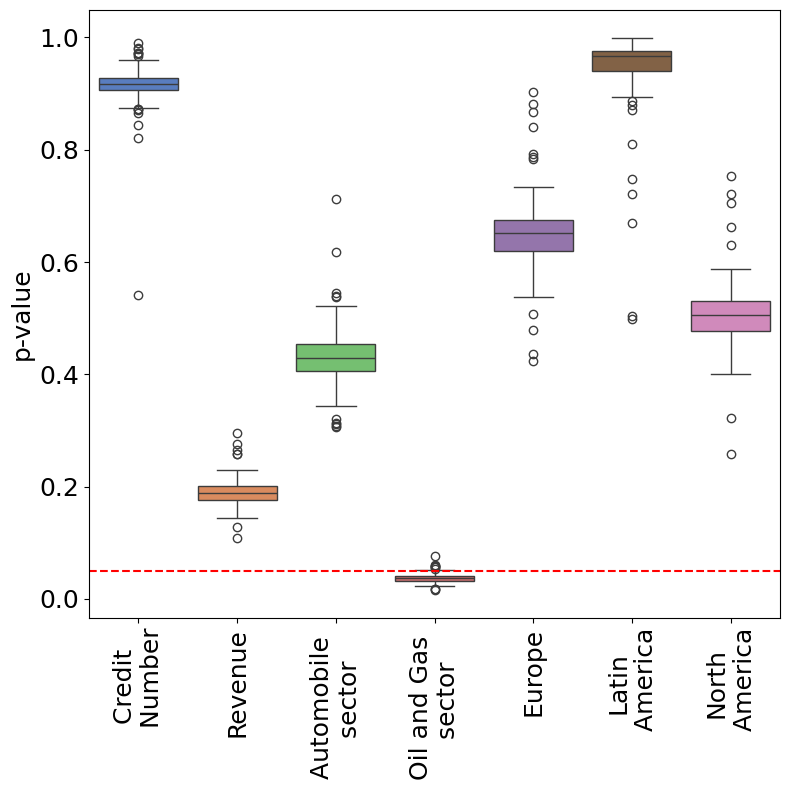

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are defined
# Selecting the predictors
predictors = ['credit_number', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']
outcome = 'scope1_difference'

# Merging the dataframes
drop_list=[11043, 866803, 9134]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]



# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True).reset_index(drop=True)

# Defining predictors and outcome variable


# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# Adding a constant term to the predictors
X_scaled_df = sm.add_constant(X_scaled_df)

# Dictionary to store p-values for each leave-one-out regression
p_values_dict = {predictor: [] for predictor in ['const'] + predictors}

# Run regressions excluding one observation at a time
for i in range(len(regression_df)):
    # Exclude one observation (row)
    X_excl = X_scaled_df.drop(i)
    y_excl = regression_df[outcome].drop(i)
    y_excl = y_excl.reset_index(drop=True)
    X_excl = X_excl.reset_index(drop=True)
    
    # Fit regression model
    model = sm.OLS(y_excl, X_excl).fit()
    
    # Store p-values for each predictor
    for predictor in p_values_dict.keys():
        p_values_dict[predictor].append(model.pvalues[predictor])

# Convert dictionary to DataFrame for easier plotting
p_values_df = pd.DataFrame(p_values_dict)

p_values_df = p_values_df.drop('const', axis=1)

# Plotting p-values for each predictor across leave-one-out iterations
plt.figure(figsize=(8, 8))

# Boxplot
sns.boxplot(data=p_values_df, palette="muted")


# Custom x-tick labels
custom_labels = ['Credit \n Number', 'Revenue', 
                 'Automobile \n sector', 'Oil and Gas \n sector', 
                 'Europe', 'Latin\n America', 
                 'North\n America']
plt.xticks(ticks=range(len(p_values_df.columns)), labels=custom_labels, rotation=0, fontsize=18)



# Add significance level line
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance level (0.05)')

plt.xticks(ticks=range(len(p_values_df.columns)), labels=custom_labels, rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('p-value', fontsize=18)

plt.xlim(-0.5, 6.5)



# Legend

plt.tight_layout()
plt.savefig('visualization/figures/INPEX_outlier_analysis/no_inpex_cont.png', dpi=900)

# Show the plot
plt.show()


In [ ]:
p_values_df.sort_values(by='credit_number')

,credit_number,revenue,Sector_Automobile,Sector_O&G,Continent_Europe,Continent_Latam,Continent_North America
56,0.541139,0.145908,0.391687,0.033431,0.537247,0.959150,0.473293
63,0.820432,0.210580,0.305703,0.017822,0.436263,0.984979,0.496450
49,0.844435,0.127607,0.308559,0.015271,0.677383,0.498560,0.511972
22,0.865369,0.143686,0.385460,0.035491,0.608099,0.977823,0.490752
69,0.870429,0.169499,0.344442,0.018545,0.648156,0.503566,0.512853
...,...,...,...,...,...,...,...
1,0.971940,0.108638,0.493492,0.027976,0.551307,0.906214,0.536097
67,0.972190,0.206589,0.425020,0.035948,0.629186,0.975689,0.498435
28,0.978510,0.265662,0.471659,0.036953,0.616283,0.966246,0.431642
68,0.980388,0.190809,0.713079,0.076666,0.423300,0.748148,0.721506


## Scope 1 Emission Development vs. binary offsetting indicator

# Scope 1 Dummy Variables 



In [ ]:

import statsmodels.api as sm




# Selecting the predictors
predictors = ['credit_bin','revenue', 'Sector_Automobile', 'Sector_O&G','Continent_Europe', 'Continent_Latam', 'Continent_North America']




drop_list=[11043, 866803, 9134]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector','TOTAL_REV_FY2018','TOTAL_REV_FY2017']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]

regression_df['credit_bin'] = (regression_df['credit_number'] > 10000).astype(int)





regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True, dtype=float)




# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)



# Adding a constant term to the predictor
X_scaled = sm.add_constant(X_scaled_df[predictors])

# Fitting the regression model
model_scope1_binary_no_interaction_scaled = sm.OLS(regression_df['scope1_difference'].reset_index(drop=True), X_scaled.reset_index(drop=True)).fit()

# Printing the summary
print(model_scope1_binary_no_interaction_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:      scope1_difference   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.317
Date:                Thu, 16 Jan 2025   Prob (F-statistic):              0.255
Time:                        09:41:30   Log-Likelihood:                -4.7659
No. Observations:                  78   AIC:                             25.53
Df Residuals:                      70   BIC:                             44.39
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/var/folders/y_/tm05xtp10jn9jjjr7109pxs00000gr/T/ipykernel_18624/1679651023.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='#1f77b4')


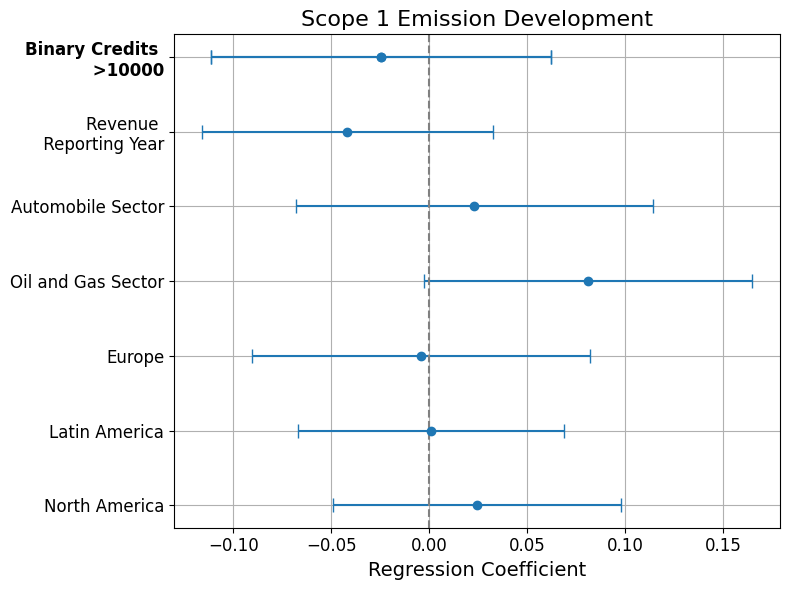

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the model has been already fitted and available as 'model'

# Extract coefficients and confidence intervals
coefficients = model_scope1_binary_no_interaction_scaled.params.drop('const')
conf = model_scope1_binary_no_interaction_scaled.conf_int()
conf['coef'] = coefficients
conf.columns = ['2.5%', '97.5%', 'coef']

# Optional: Standardize coefficients
X_std = regression_df[['credit_number', 'revenue', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']].std()
y_std = regression_df['scope1_difference'].std()
conf['coef_std'] = conf['coef'] * X_std / y_std
conf['2.5%_std'] = conf['2.5%'] * X_std / y_std
conf['97.5%_std'] = conf['97.5%'] * X_std / y_std

# Reverse the order of predictors
conf = conf[::-1]

# Manually set predictor names
conf.index = ['North America', 'Latin America', 'Europe',  'Oil and Gas Sector','Automobile Sector', 'Revenue Reporting Year',  'Number of Retired Credits', 'const']

# Plotting the coefficients
plt.figure(figsize=(8, 6))
plt.errorbar(conf['coef'], conf.index, xerr=(conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']), fmt='o', capsize=5)
plt.axvline(0, color='grey', linestyle='--')
plt.title('Scope 1 Emission Development', fontsize=16)


# Introduce a line break in the specific y-tick label
new_labels = conf.index.tolist()

position = len(conf) - 3
new_labels[position] = 'Revenue \n Reporting Year'  # Adding line break



position = len(conf) - 2
new_labels[position] = 'Binary Credits \n >10000'   # Adding line break
plt.yticks(ticks=range(len(conf)), labels=new_labels, fontsize=12)
plt.xticks( fontsize=12)



position=len(conf)-2
# Change the color of the uppermost point and error bar
plt.errorbar(conf['coef'][position], conf.index[position], xerr=[[conf['coef'][position] - conf['2.5%'][position]], [conf['97.5%'][position] - conf['coef'][position]]], fmt='o', capsize=5, color='#1f77b4')

# Highlight the uppermost ylabel
plt.gca().get_yticklabels()[position].set_color('black')
plt.gca().get_yticklabels()[position].set_fontweight('bold')

#plt.ylabel('Predictors')
plt.xlabel('Regression Coefficient', fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.savefig('visualization/figures/effect_size/scope1_regression.png', dpi=900)

### Leave-one-out Cross Validatoin
For each regression run one observation is dropped. Below is distrubtion of p-values

#### Version 1: INPEX is part of sample
Red dot marks iteration where INPEX is dropped

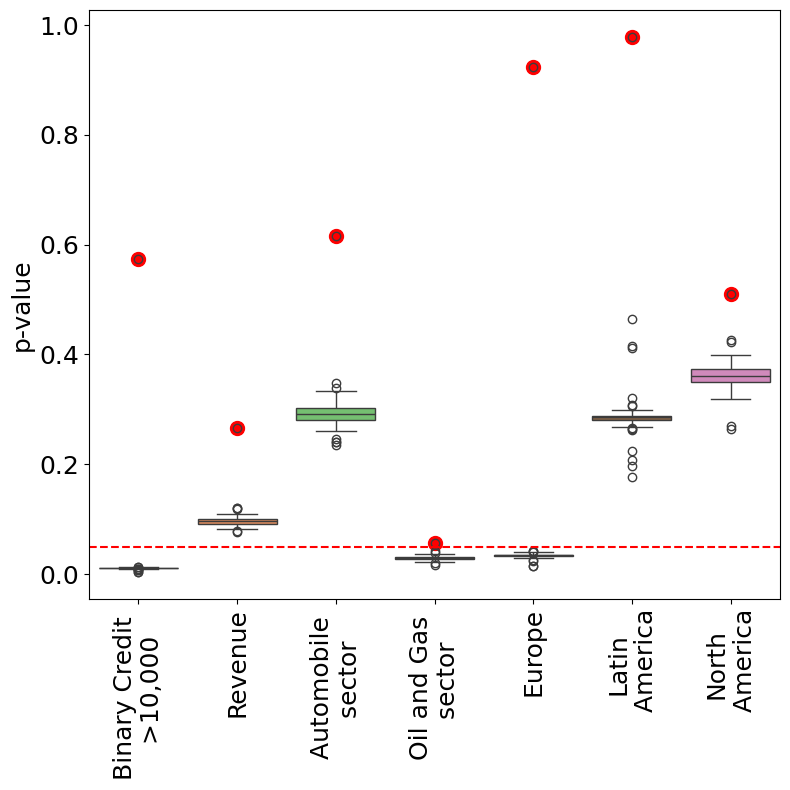

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are defined
# Selecting the predictors
predictors = ['credit_bin', 'revenue', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']
outcome = 'scope1_difference'

# Merging the dataframes
drop_list=[11043, 866803]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]

regression_df['credit_bin'] = (regression_df['credit_number'] > 10000).astype(int)


# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True).reset_index(drop=True)

# Defining predictors and outcome variable


# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# Adding a constant term to the predictors
X_scaled_df = sm.add_constant(X_scaled_df)

# Dictionary to store p-values for each leave-one-out regression
p_values_dict = {predictor: [] for predictor in ['const'] + predictors}

# Run regressions excluding one observation at a time
for i in range(len(regression_df)):
    # Exclude one observation (row)
    X_excl = X_scaled_df.drop(i)
    y_excl = regression_df[outcome].drop(i)
    y_excl = y_excl.reset_index(drop=True)
    X_excl = X_excl.reset_index(drop=True)
    
    # Fit regression model
    model = sm.OLS(y_excl, X_excl).fit()
    
    # Store p-values for each predictor
    for predictor in p_values_dict.keys():
        p_values_dict[predictor].append(model.pvalues[predictor])


# Dictionary to store p-values for each leave-one-out regression
p_values_dict = {predictor: [] for predictor in ['const'] + predictors}

# Run regressions excluding one observation at a time
for i in range(len(regression_df)):
    # Exclude one observation (row)
    X_excl = X_scaled_df.drop(i)
    y_excl = regression_df[outcome].drop(i)
    y_excl = y_excl.reset_index(drop=True)
    X_excl = X_excl.reset_index(drop=True)
    
    # Fit regression model
    model = sm.OLS(y_excl, X_excl).fit()
    
    # Store p-values for each predictor
    for predictor in p_values_dict.keys():
        p_values_dict[predictor].append(model.pvalues[predictor])

# Convert dictionary to DataFrame for easier plotting
p_values_df = pd.DataFrame(p_values_dict)
p_values_df = p_values_df.drop('const', axis=1)


# Plotting p-values for each predictor across leave-one-out iterations
plt.figure(figsize=(8, 8))

# Boxplot
sns.boxplot(data=p_values_df, palette="muted")

# Add scatter points
sns.stripplot(data=p_values_df, color="gray", alpha=0.0, jitter=True, size=8)

index_inpex=regression_df[regression_df['CDP_ID']==9134].index[0]
for col in p_values_df.columns:
    plt.scatter(x=[col], y=[p_values_df.at[index_inpex, col]], color="red", s=100, label='Inpex Corporation left out' if col == p_values_df.columns[0] else "")

# Add significance level line
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance level (0.05)')

custom_labels = ['Binary Credit \n >10,000', 'Revenue', 
                 'Automobile \n sector', 'Oil and Gas \n sector', 
                 'Europe', 'Latin\n America', 
                 'North\n America']
plt.xticks(ticks=range(len(p_values_df.columns)), labels=custom_labels, rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('p-value', fontsize=18)

plt.xlim(-0.5, 6.5)

#plt.title('Leave-One-Out Iterations including INPEX Corporation', fontsize=16)

# Legend
#plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1, 0.7))
plt.tight_layout()


plt.savefig('visualization/figures/INPEX_outlier_analysis/with_inpex_binary.png', dpi=900)

# Show the plot
plt.show()




#### Version 2: Inpex is not part of sample
No matter what other company is dropped from the sample, carbon ofsetting is nowhere near significance level.

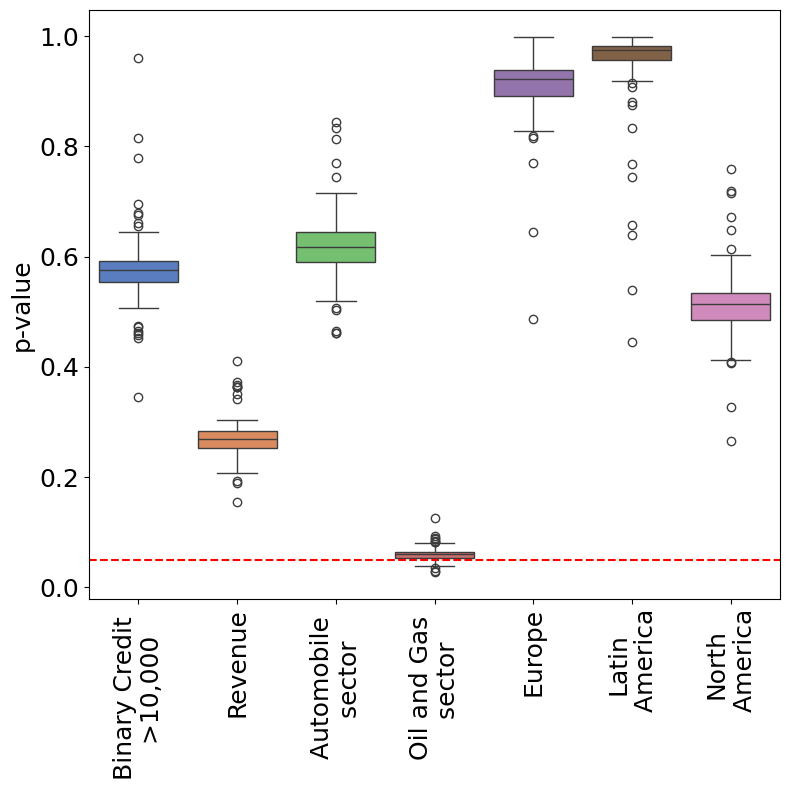

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming ambition and control_var are defined
# Selecting the predictors
predictors = ['credit_bin', 'revenue', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']
outcome = 'scope1_difference'

# Merging the dataframes
drop_list=[11043, 866803, 9134]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]

regression_df['credit_bin'] = (regression_df['credit_number'] > 10000).astype(int)


# Creating dummy variables for categorical data
regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True).reset_index(drop=True)

# Defining predictors and outcome variable


# Standardizing the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(regression_df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# Adding a constant term to the predictors
X_scaled_df = sm.add_constant(X_scaled_df)

# Dictionary to store p-values for each leave-one-out regression
p_values_dict = {predictor: [] for predictor in ['const'] + predictors}


# Run regressions excluding one observation at a time
for i in range(len(regression_df)):
    # Exclude one observation (row)
    X_excl = X_scaled_df.drop(i)
    y_excl = regression_df[outcome].drop(i)
    y_excl = y_excl.reset_index(drop=True)
    X_excl = X_excl.reset_index(drop=True)
    
    # Fit regression model
    model = sm.OLS(y_excl, X_excl).fit()
    
    # Store p-values for each predictor
    for predictor in p_values_dict.keys():
        p_values_dict[predictor].append(model.pvalues[predictor])


# Convert dictionary to DataFrame for easier plotting
p_values_df = pd.DataFrame(p_values_dict)
p_values_df = p_values_df.drop('const', axis=1)

# Plotting p-values for each predictor across leave-one-out iterations
plt.figure(figsize=(8, 8))

# Boxplot
sns.boxplot(data=p_values_df, palette="muted")



# Add significance level line
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance level (0.05)')

custom_labels = ['Binary Credit \n >10,000', 'Revenue', 
                 'Automobile \n sector', 'Oil and Gas \n sector', 
                 'Europe', 'Latin\n America', 
                 'North\n America']
plt.xticks(ticks=range(len(p_values_df.columns)), labels=custom_labels, rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('p-value', fontsize=18)

# Legend
#plt.legend()
plt.tight_layout()
plt.savefig('visualization/figures/INPEX_outlier_analysis/no_inpex_binary.png', dpi=900)

# Show the plot
plt.show()



## Logistic Regression - probability of decarbonisation 2017-2022

As suggested by industry input - logistic regression to evaluate probability of decarbonisation over study period

In [ ]:
#Logistic Regression Decarbonisation

import statsmodels.api as sm


# Selecting the predictors
predictors = ['credit_number', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']




drop_list=[11043, 866803, 9134]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]


regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)


# Adding a binary variable for emission reduction
regression_df['emission_reduction_binary']=(regression_df['scope1_difference'] < 1).astype(int)






# Selecting the predictors
predictors = ['credit_number', 'revenue', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = sm.add_constant(scaler.fit_transform(regression_df[predictors]))


# Fitting the regression model
model_prob_decarb = sm.Logit(regression_df['emission_reduction_binary'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_prob_decarb.summary())

Optimization terminated successfully.
         Current function value: 0.599816
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     emission_reduction_binary   No. Observations:                   78
Model:                                 Logit   Df Residuals:                       70
Method:                                  MLE   Df Model:                            7
Date:                       Thu, 16 Jan 2025   Pseudo R-squ.:                 0.04375
Time:                               09:41:39   Log-Likelihood:                -46.786
converged:                              True   LL-Null:                       -48.926
Covariance Type:                   nonrobust   LLR p-value:                    0.7469
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8005      0.255      3.138      0.0

In [ ]:
#Logistic Regression Decarbonisation

import statsmodels.api as sm


# Selecting the predictors
predictors = ['credit_bin', 'revenue', 
              'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']




drop_list=[11043, 866803, 9134]

regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df = regression_df[~regression_df['CDP_ID'].isin(drop_list)]
regression_df = regression_df[regression_df['scope1_difference'].notna()]


regression_df = pd.get_dummies(regression_df, columns=['Sector', 'Continent'], drop_first=True)


# Adding a binary variable for emission reduction
regression_df['emission_reduction_binary']=(regression_df['scope1_difference'] < 1).astype(int)

regression_df['credit_bin'] = (regression_df['credit_number'] > 10000).astype(int)





# Selecting the predictors
predictors = ['credit_bin', 'revenue', 'Sector_Automobile', 'Sector_O&G', 'Continent_Europe', 'Continent_Latam', 'Continent_North America']

# Standardizing the predictors
scaler = StandardScaler()
X_scaled = sm.add_constant(scaler.fit_transform(regression_df[predictors]))


# Fitting the regression model
model_prob_decarb = sm.Logit(regression_df['emission_reduction_binary'].reset_index(drop=True), X_scaled).fit()

# Printing the summary
print(model_prob_decarb.summary())

Optimization terminated successfully.
         Current function value: 0.597427
         Iterations 5
                               Logit Regression Results                              
Dep. Variable:     emission_reduction_binary   No. Observations:                   78
Model:                                 Logit   Df Residuals:                       70
Method:                                  MLE   Df Model:                            7
Date:                       Thu, 16 Jan 2025   Pseudo R-squ.:                 0.04755
Time:                               09:41:39   Log-Likelihood:                -46.599
converged:                              True   LL-Null:                       -48.926
Covariance Type:                   nonrobust   LLR p-value:                    0.7022
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8007      0.254      3.148      0.0

In [ ]:
regression_df = pd.merge(scope1.reset_index().rename(columns={'index':'CDP_ID'}), control_var[['CDP_ID', 'revenue', 'EBITDA_FY2023','TOTAL_ASSETS_FY2023','Continent', 'Sector']], on='CDP_ID', how='left')
regression_df[regression_df['company_name'].str.contains('INPEX')]

,CDP_ID,company_name,scope1_2023,scope1_2018,scope1_difference,credit_spent,credit_number,credit_2018_2023,revenue,EBITDA_FY2023,TOTAL_ASSETS_FY2023,Continent,Sector


In [ ]:
scope1.sort_values(by='scope1_difference', ascending=False).head(10)

,company_name,scope1_2023,scope1_2018,scope1_difference,credit_spent,credit_number,credit_2018_2023
9134,Inpex Corporation,6.338586e+06,584309.0,10.848003,1271959.78,250791.0,788620.0
17929,Suncor Energy Inc.,3.351528e+07,32412166.0,1.810724,0.00,0.0,0.0
19304,TC Energy,2.113225e+07,12500000.0,1.690580,0.00,0.0,0.0
1800,Bharat Petroleum Corporation,6.681830e+06,3962290.0,1.686356,0.00,0.0,NaN
13649,Occidental Petroleum Corporation,1.760134e+07,11300000.0,1.557641,24600.00,240.0,240.0
15297,PTT,4.454382e+07,43190517.0,1.476751,0.00,0.0,30.0
11267,Mahindra & Mahindra,5.893600e+04,56789.0,1.410728,0.00,0.0,0.0
14774,ORLEN S.A.,2.064308e+07,15226911.0,1.355697,0.00,0.0,0.0
22213,Ryanair Holding PLC,1.426619e+07,10765881.0,1.325129,1710000.00,200000.0,NaN
11043,PJSC Lukoil,4.120160e+07,31140000.0,1.323109,0.00,0.0,0.0
